# Heart Sound Classification

## Exploratory Data Analysis

### Sound Samples

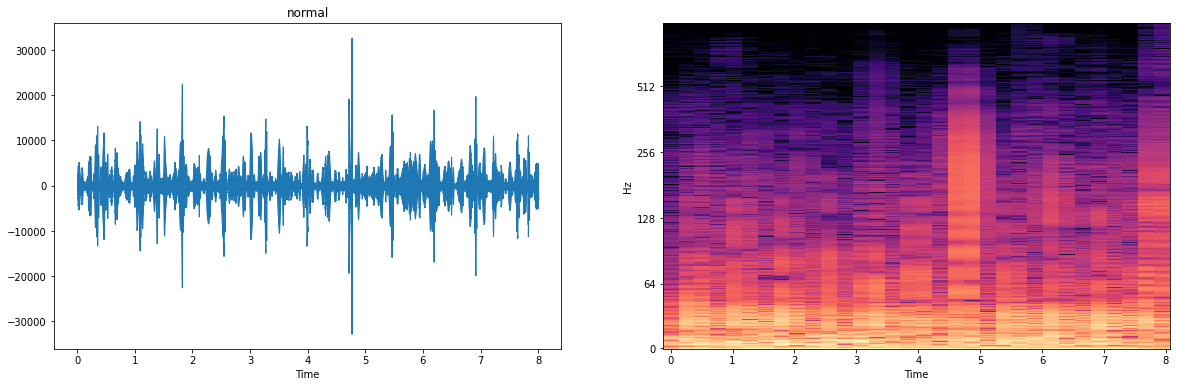

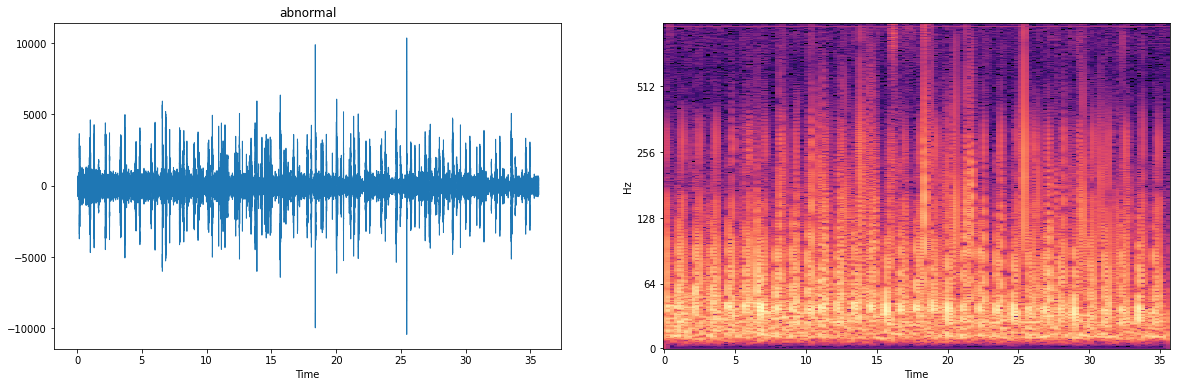

In [1]:
from utils import load_physioNet
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import IPython.display as ipd

physio_sounds = load_physioNet()

np.random.seed(0)
a = np.random.randint(0, 500)

normal_sound = physio_sounds[physio_sounds[:,1] == 'normal'][a][0]
abnormal_sound = physio_sounds[physio_sounds[:,1] == 'abnormal'][a][0]

sample_sounds = [(normal_sound, "normal"), (abnormal_sound, "abnormal")]

for sound in sample_sounds:
    sample_sound, title = sound
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
    librosa.display.waveshow(sample_sound, sr=2000, ax=axs[0])
    X = librosa.stft(sample_sound)
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=2000, x_axis='time', y_axis='log', ax=axs[1])
    axs[0].set_title(title)
    plt.show()
    display(ipd.Audio(sample_sound, rate=2000))

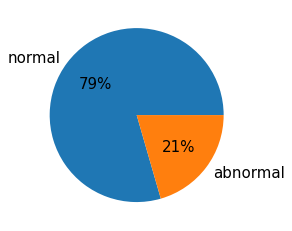

In [2]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
normal_cnt, abnormal_cnt = pd.DataFrame(physio_sounds[:,1]).value_counts(normalize=True)
ax.pie([normal_cnt,abnormal_cnt], labels=["normal", "abnormal"], autopct='%.0f%%', textprops={'fontsize':15})
plt.show()

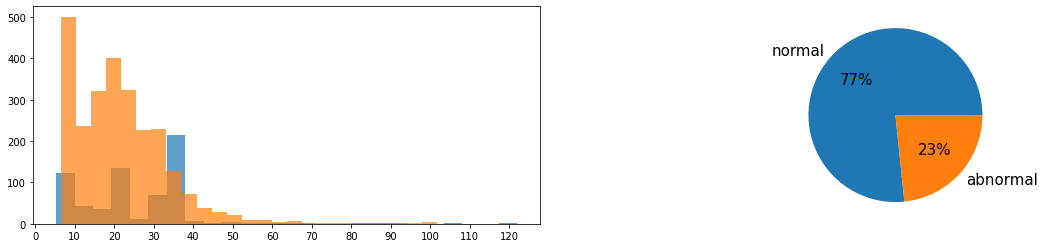

In [3]:
_, axs = plt.subplots(ncols=2, figsize=(20,4))
abnormal_seconds = [len(sound)/2000 for sound in physio_sounds[physio_sounds[:,1] == 'abnormal'][:, 0]]
normal_seconds = [len(sound)/2000 for sound in physio_sounds[physio_sounds[:,1] == 'normal'][:, 0]]

axs[0].hist(abnormal_seconds, bins=25, alpha = 0.7)
axs[0].hist(normal_seconds, bins=25, alpha = 0.7)
axs[0].set_xticks(range(0, 130, 10))
total_normal_seconds = np.sum(normal_seconds)
total_abnormal_seconds = np.sum(abnormal_seconds)
total_seconds = total_abnormal_seconds + total_normal_seconds
axs[1].pie([total_normal_seconds, total_abnormal_seconds], labels=["normal", "abnormal"], autopct='%.0f%%', textprops={'fontsize':15})
plt.show()

# Preprocssing

## Wavelet Denoising
#### Wavelets denoising has proven improvments in heart sound as it decreases the SNR which helps in better analysis of heart sound

![](./docs/db6.png)

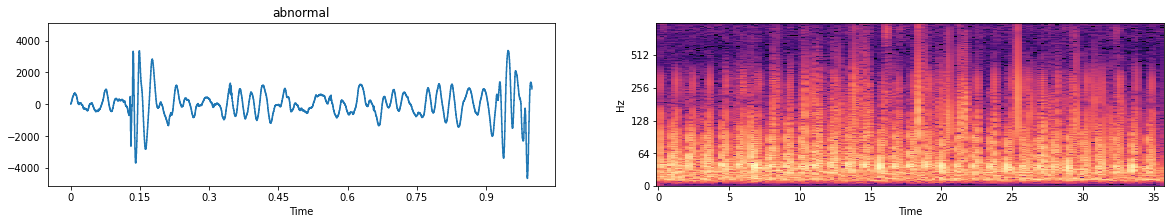

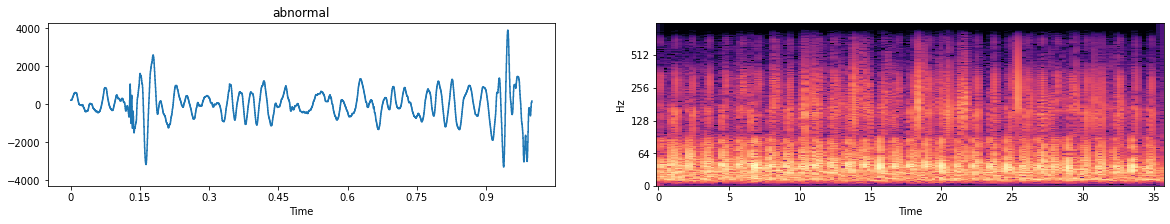

In [4]:
from utils import db6_wavelet_denoise

sample_sound, title = abnormal_sound, "abnormal"
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,3))
librosa.display.waveshow(sample_sound[:2000], sr=2000, ax=axs[0])
X = librosa.stft(sample_sound)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=2000, x_axis='time', y_axis='log', ax=axs[1])
axs[0].set_title(title)
plt.show()

sample_sound, title = db6_wavelet_denoise(abnormal_sound), "abnormal"
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,3))
librosa.display.waveshow(sample_sound[:2000], sr=2000, ax=axs[0])
X = librosa.stft(sample_sound)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=2000, x_axis='time', y_axis='log', ax=axs[1])
axs[0].set_title(title)
plt.show()

## Feature Extraction

#### Features are extracted from the wav files after loading and we can catergorize them into : -
- Signal & Information Theory Features
- Statsitical Features
- Mel Frequency Features (MFCCs)

#### The feature vector is as follows

|Max_Amplitude|Dominant_Freq|Entropy|Mean|Median|STD|Kurtosis|Skewness|IQR|First_Percentile|Second_Percentile|Third_Percentile|MFCC1|MFCC2|MFCC3|MFCC4|MFCC5|MFCC6|MFCC7|MFCC8|MFCC9|MFCC10|MFCC11|MFCC12|MFCC13|
|---------- |---------- |---------- |---------- |---------- |---------- |---------- |---------- |---------- |---------- |---------- |---------- |---------- |---------- |---------- |---------- |---------- |---------- |---------- |---------- |---------- |---------- |---------- |---------- |---------- |




#### For example for feature extraction from sound we apply our method `extract_segment_features` to the sound we need to process

In [5]:
from feature_extraction import extract_segment_features
print([extract_segment_features(normal_sound)])

[[17038.0, 0.0, 7.898190182578632, -1588.6985, -1226.5, 3761.9675, 2.883898622137873, -0.6348435470033976, 3974.5, -3458.5, -1226.5, 516.0, 738.21155, 181.47565, 35.146038, 35.86279, 16.046211, 22.943117, 10.562052, 15.224125, 12.249605, 14.513554, 6.5780296, 8.349518, 4.464912]]


#### In our case we can benefit that the sound recordings contains many heart sound cycles so segmenting the heart sound by taking every N cycles togther and we have found N to be 5 is a good number to be able to get useful features and more data segments

In [6]:
from segmentation import build_segements
segmented_sounds = build_segements(physio_sounds, sr=2000)
print(len(segmented_sounds))

16749


#### After creating the segements we will extract the features form them and build out dataframe of features to train with using `construct_dataframe`

In [7]:
import os
from feature_extraction import construct_dataframe

if(not os.path.exists("physioNet.csv")):
    construct_dataframe("physioNet")
print("---------------------- DataSet is Ready ----------------------")

---------------------- DataSet is Ready ----------------------


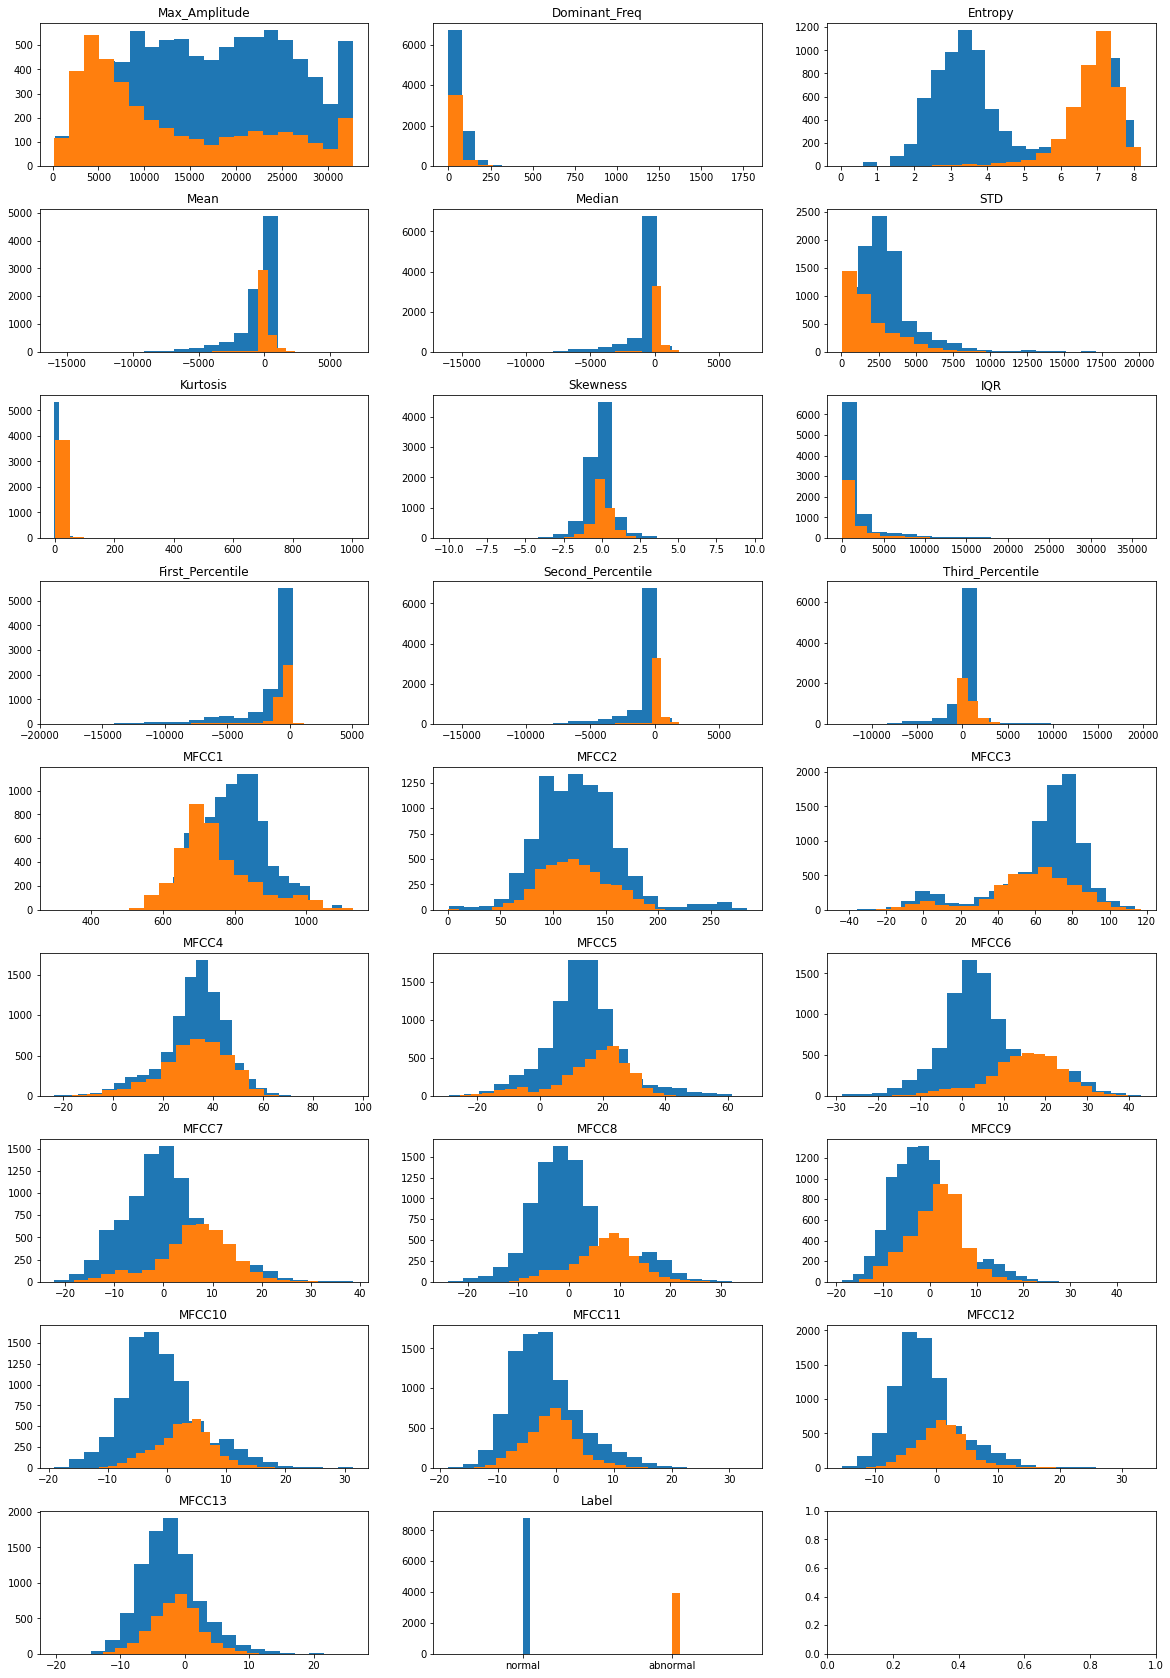

In [8]:
from utils import features_histo
import pandas as pd

hs_df = pd.read_csv("physioNet.csv")
hs_df = hs_df.drop(columns=["Unnamed: 0"])
hs_df = hs_df.sort_values(by='Label', ascending=False)
hs_df = hs_df.tail(hs_df.shape[0]-4000)

normal_df = hs_df[hs_df["Label"] == "normal"]
abnormal_df = hs_df[hs_df["Label"] == "abnormal"]

dfs = [normal_df, abnormal_df]
features_histo(dfs)

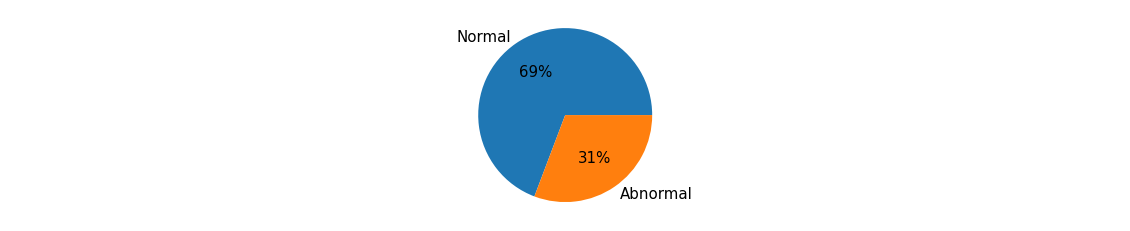

In [9]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
normal_cnt, abnormal_cnt = tuple(hs_df["Label"].value_counts(normalize=True))
axs[1].pie([normal_cnt,abnormal_cnt], labels=["Normal", "Abnormal"], autopct='%.0f%%', textprops={'fontsize':15})
axs[0].axis('off')
axs[2].axis('off')
plt.show()